In [1]:
# load in packages
import itertools

import datetime

from test_results import test_results, score

import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn as sk
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [2]:
train_data.groupby(['Promotion','purchase'])['ID'].count().reset_index().rename({'ID':'count'}, axis=1)


,Promotion,purchase,count
0,No,0,41851
1,No,1,319
2,Yes,0,41643
3,Yes,1,721


# 1. First analyze the difference in purchase rates between the control group and experimental group

In [3]:
def p_evaluation_metrics(n_control, 
                        n_exper, 
                        p_null, 
                        p_click_control,
                        p_click_exper,
                        alt="larger"):
    
    """
    Statistical test to determine if we reached our goal;
    
    Input:
        n_control: size of control group
        n_exper: size of experiment group
        p_click_control: goal hit rate for control group
        p_click_exper: goal hit rate for experiment group
        alt: the relationship between p_click_control and p_click_exper in alternative hypothesis;
             larger: p_click_exper > p_click_control
             small: p_click_exper < p_click_control
             different: p_click_exper is not equal to p_click_control
    """
    
    # compute standard error, z-score, and p-value
    se_p = np.sqrt(p_null * (1-p_null) * (1/n_control + 1/n_exper))
    z = (p_click_exper - p_click_control) / se_p
    if alt == "larger":
        p_result = 1-stats.norm.cdf(z)
    elif alt == "smaller":
        p_result = stats.norm.cdf(z)
    elif alt == "different":
        p_result = 2 * stats.norm.cdf(-abs(z))
    print("Success rate for control group: {}; Success rate for experiment group: {}".format(round(p_click_control, 4), round(p_click_exper, 4)))
    print("p value: {}".format(round(p_result, 4)))

In [4]:
p_evaluation_metrics(sum(train_data['Promotion'] == "No"),
                     sum(train_data['Promotion'] == "Yes"),
                     train_data['purchase'].mean(),
                     train_data[train_data['Promotion'] == "No"]['purchase'].mean(),
                     train_data[train_data['Promotion'] == "Yes"]['purchase'].mean(),
                     alt="different")

Success rate for control group: 0.0076; Success rate for experiment group: 0.017
p value: 0.0


# Functon for evaluating data processing, model evaluation and tuning

Our metrics IRR and NIR, all emphasize the idea that we will not only look for increasing the conversions, but also optimizing the ad cost. A very important strategy is to avoid sending ads to customers who are more likely to buy even without seeing the ad and customers who are not likely to buy even when they see the ad. It's ideal to send ads to customers who might not feel interested before they see the ad, but have high chances to convert after they see the ad.

Also, when training the model we have to deal with the imbalance in data. As we can see from the analysis above, the conversion rate is very low --- even for experiment group that's 1.7%. If we don't deal with this issue, our model could predict every sample as negative --- the accuracy will still be 98%!

To handle data imbalance, we upsample the purchase group and downsample the non-purchase group seperately for control and experiment group --- the sizes of the resampled groups are also tunable. Also, when we split the training data to train set and validation set (usually known as train_test_split), we did a stratified sampling to avoid the senario where there's no positive records in validation set and to make sure that the validation set is close to a real world testing data.

When tuning the model, we focused mostly on the loss from errors rather than gainings from giving the ads to the right people. It actually worked quite well in the end. More details can be founded in the docstring in the function evaluate. The reason why we didn't consider true positives here to "reward" the model is that when we trained the models, we greatly balanced the data --- we greatly upsampled the purchase group and only sample a little (no more than 10%) from non-purchase group , so we can expect that recall is usually higher than precision. In other words, our model might have done its best to recognize the customers who will make purchases but it can be over optimistic. We want to correct that since giving promotion ads to too many people can greatly increase the cost of the campaign.

In [5]:
def customize_train_test_split(data,
                               tag_col,
                               minority_tag_value):
    
    """
    Do train_test_split on minority group and majority group seperately
    -- sample 20% minority and 20% majority to the final test set
    
    This process doesn't drop any columns
    
    Input:
        data: the data to split
        tag_col: column for the class label
        minority_tag_value: class label that has very few representatives
    """
    
    data_minor = data[data[tag_col] == minority_tag_value]
    data_major = data[data[tag_col] != minority_tag_value]
    
    train_minor, test_minor = train_test_split(data_minor, test_size=0.2)
    train_major, test_major = train_test_split(data_major, test_size=0.2)
    
    train = pd.concat([train_minor, train_major]).sample(frac=1)
    test = pd.concat([test_minor, test_major]).sample(frac=1)
    
    return train, test

In [6]:
def resampler(data, 
              tag_col,
              minority_tag_value,
              minority_group_size,
              majority_group_size):
    
    """
    Handle the imbalanced data
    
    For minority group we upsample the data with replacement; 
    For majority group we downsample the data without replacement;
    
    This process doesn't drop any columns
    
    Input:
        data: the data to split
        tag_col: column for the class label
        minority_tag_value: class label that has very few representatives
        minority_group_size: group size of the minority group after resampling
        majority_group_size: group size of the majority group after resampling
    """
    
    minority_resample = resample(data[data[tag_col] == minority_tag_value], 
                                 replace=True,
                                 n_samples=minority_group_size)
    majority_resample = resample(data[data[tag_col] != minority_tag_value], 
                                 replace=False,
                                 n_samples=majority_group_size)
    resampled_data = pd.concat([minority_resample, majority_resample])
    return resampled_data


In [7]:
def train_model(X, y, learning_rate=0.1, max_depth=10, min_samples_split=2):
    
    """
    A general function for a machine learning pipeline of 
    (1) scaling all the variables
    (2) training a GradientBoostingClassifier with specified parameters
    
    The model returned is a trained Pipeline object
    """
    
    clf = GradientBoostingClassifier(learning_rate=learning_rate, 
                                 max_depth=max_depth, 
                                 min_samples_split=min_samples_split)
    
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])
    
    model.fit(X, y)

    return model

In [8]:
def test_model(model, X, y):
    
    """
    A general function for checking the f1, precision and recall score of the model;
    Actually we won't use it since we will have different scoring function for tuning the model,
    but when building the model we might want to have a look at these more "traditional" scorings 
    to understand how our model is performing
    
    Output is a dictionary with 'precision', 'recall' and 'f1'
    """
    
    y_pred = model.predict(X)
    result = {}
    result['precision'] = precision_score(y, y_pred)
    result['recall'] = recall_score(y, y_pred)
    result['f1'] = f1_score(y, y_pred)
    return result

In [9]:
def train_model_full(train, 
                     minority_group_size, 
                     majority_group_size, 
                     learning_rate=0.1, 
                     max_depth=10, 
                     min_samples_split=2):
    
    """
    A general function of of resampling the data and training a model.
    
    Input:
        train: the training data (after train_test_split)
        minority_group_size: group size of the minority group after resampling
        majority_group_size: group size of the majority group after resampling
        learning_rate: parameter for GradientBoostingClassifier 
        max_depth: parameter for GradientBoostingClassifier 
        min_samples_split: parameter for GradientBoostingClassifier 
    """
    
    re_train = resampler(train, "purchase", 1, minority_group_size, majority_group_size)
    X = re_train[['V1','V2','V3','V4','V5','V6','V7']]
    y = re_train['purchase']
    model = train_model(X, 
                        y, 
                        learning_rate=learning_rate, 
                        max_depth=max_depth, 
                        min_samples_split=min_samples_split)
    
    return model

In [10]:
def generate_promotion_customer_list(data,
                                     data_to_predict,
                                     control_minority_group_size,
                                     control_majority_group_size,
                                     expr_minority_group_size,
                                     expr_majority_group_size,
                                     learning_rate=0.1, 
                                     max_depth=10, 
                                     min_samples_split=2):
    
    """
    Train 2 models to predict whether a customer will buy the product:
    --- one on control group and another one on experiemnt group
    
    Predict with the 2 models:
    --- result from the model trained on control group: whether a customer
        will purchase if they don't see the ad
    --- result from the model trained on experiment group: whether a customer
        will purchase if they see the ad
        
    This function might not be well named :) Because it doesn't directly generate the 
    promotion customer list. 
    
    Input:
        data: the training data (after train_test_split)
        data_to_predict: testing data or validation data
        control_minority_group_size: group size of the purchase control group after resampling
        control_majority_group_size: group size of the non-purchase control group after resampling
        expr_minority_group_size: group size of the purchase experiment group after resampling
        expr_majority_group_size: group size of the non-purchase experiment group after resampling
        learning_rate: parameter for GradientBoostingClassifier 
        max_depth: parameter for GradientBoostingClassifier 
        min_samples_split: parameter for GradientBoostingClassifier 
        
    
    The output is the table data_to_predict with 2 extra columns:
        purchase without ad: whether a customer will purchase if they don't see the ad
        purchase with ad: whether a customer will purchase if they see the ad
    """
    
    model1 = train_model_full(data[data['Promotion'] == "No"],
                              control_minority_group_size,
                              control_majority_group_size,
                              learning_rate=learning_rate, 
                              max_depth=max_depth, 
                              min_samples_split=min_samples_split)
    
    y1 = model1.predict(data_to_predict[['V1','V2','V3','V4','V5','V6','V7']])
    
    data_to_predict['purchase without ad'] = y1
    
    model2 = train_model_full(data[data['Promotion'] == "Yes"],
                              expr_minority_group_size,
                              expr_majority_group_size,
                              learning_rate=learning_rate, 
                              max_depth=max_depth, 
                              min_samples_split=min_samples_split)
    
    y2 = model2.predict(data_to_predict[['V1','V2','V3','V4','V5','V6','V7']])
    
    data_to_predict['purchase with ad'] = y2
    
    return data_to_predict


In [11]:
def evaluate(y_pred_pd):
    
    """
    We mainly focus on the loss (rather than the people we successfully predicted that will make purchase)
    
    ### Check control group
    If we predict that the customer will buy without ad but actually they didn't buy
     -> under this case we won't promote to the customer
     ---- if the customer won't buy either after seeing the ad then we are fine;
     ---- if the customer will buy after seeing the ad then we are losing $(10 - 0.15) --> Based on the data from 
          the previous round, 1.7% of the people who saw ads will buy 
    if we predict that the customer won't buy without ad but actually they bought
     -> we actually don't need to promote to the customer but if we also predict that they will buy with the ad we 
        will end up promote to them. Then we are losing $0.15
        
    ### Check experiment group
    if we predict that the customer will buy with the ad but actually they didn't 
     ---- if we also predict that they will buy without the ad then we are fine
     ---- if not, we are giving them the ad while we don't need to. Then we are losing $0.15
    if we predict that the customer won't buy with the ad but they bought
     -> under this case we won't give them the ad. 
     ---- if the customer won't buy without ad --> we should've gave them the ad --> we are losing $(10 - 0.15) -->
          (100% - 0.76%) of the people won't buy without ad
     ---- if the customer will buy without ad then we are fine
     
    """
    
    y_pred_control = y_pred_pd[y_pred_pd['Promotion'] == "No"]
    y_pred_expr = y_pred_pd[y_pred_pd['Promotion'] == "Yes"]
    
    loss = 0.017 * (10 - 0.15) * sum((y_pred_control['purchase without ad'] == 1) & \
                                     (y_pred_control['purchase'] == 0)) + \
           0.15 * sum((y_pred_control['purchase without ad'] == 0) & \
                      (y_pred_control['purchase'] == 1) & \
                      (y_pred_control['purchase with ad'] == 1)) + \
           0.15 * sum((y_pred_expr['purchase with ad'] == 1) & \
                      (y_pred_expr['purchase'] == 0) & \
                      (y_pred_expr['purchase without ad'] == 0)) + \
           (1 - 0.0076) * (10 - 0.15) * sum((y_pred_expr['purchase with ad'] == 0) & \
                                            (y_pred_expr['purchase'] == 1)) 
    
    return loss

## 3. Tune the model --- find the best parameters

Parameters for us train include:

**control_minority_group_size:** group size of the purchase control group after resampling<br>
**control_majority_group_size:** group size of the non-purchase control group after resampling<br>
**expr_minority_group_size:** group size of the purchase experiment group after resampling<br>
**expr_majority_group_size:** group size of the non-purchase experiment group after resampling<br>
**learning_rate:** parameter for GradientBoostingClassifier<br>
**max_depth:** parameter for GradientBoostingClassifier<br>
**min_samples_split:** parameter for GradientBoostingClassifier<br>



## 3.1 Split our original data train_data to trainning set and testing set

In each dataset, control group data and experiment data are mixed together because there's a column Promotion to indicate whether a record is in one group or another. Later in our functions we will be able to split them.4



In [12]:
control_train, control_test = customize_train_test_split(train_data[train_data['Promotion'] == "No"], "purchase", 1)
expr_train, expr_test = customize_train_test_split(train_data[train_data['Promotion'] == "Yes"], "purchase", 1)
train = pd.concat([control_train, expr_train])
test = pd.concat([control_test, expr_test])

# 3.2 Specify the candidate values for each variable and create a list of all combinations of the values


In [13]:
control_minority_group_size = [1000, 1200]
control_majority_group_size = [2000, 3000]
expr_minority_group_size = [3000, 4000]
expr_majority_group_size = [4000, 5000]
learning_rate = [0.01, 0.02]
max_depth = [6, 8]
min_samples_split = [2, 4]

In [14]:
params = list(itertools.product(*[control_minority_group_size, 
                         control_majority_group_size,
                         expr_minority_group_size,
                         expr_majority_group_size,
                         learning_rate,
                         max_depth,
                         min_samples_split]))

# 3.3 Gridsearch on the variables

For each parameter combination, we run generate_promotion_customer_list 5 times and then calculate average loss. This is an approximate methods to 5 folds cross validation. Rather than spliting the data to 5 folds ahead and use one fold as validation set at one time, we randomly split data each time we run the model. This might be the laziness of the author :) and can be improved by 5 folds validation in the future.

In [15]:
loss_list = []
begin = datetime.datetime.now()
for p in params: 
    l = []
    for i in range(5):
        y_pred_pd = generate_promotion_customer_list(train,
                                                     test,
                                                     p[0],
                                                     p[1],
                                                     p[2],
                                                     p[3],
                                                     p[4],
                                                     p[5])
        l.append(evaluate(y_pred_pd))

    loss_list.append(l)
time_pass = (datetime.datetime.now() - begin).seconds / 60
print("running time: {:.2} min".format(time_pass))
average_loss_list = list(np.mean(np.array(loss_list), axis=1))
print("Minimum average loss: {}".format(min(average_loss_list)))
best_params = params[average_loss_list.index(min(average_loss_list))]
print("Best params : {}".format(best_params))

running time: 3e+01 min
Minimum average loss: 1021.753772
Best params : (1000, 3000, 4000, 4000, 0.01, 6, 4)


3.4 The best parameters and minimum average loss


In [16]:
average_loss_list = list(np.mean(np.array(loss_list), axis=1))


In [17]:
#minimum average loss
min(average_loss_list)

1021.753772

In [18]:
test_model(train_model_full(train[train['Promotion'] == "No"], 
                     1200, 
                     2000, 
                     learning_rate=0.01, 
                     max_depth=6, 
                     min_samples_split=2),
                test[['V1','V2','V3','V4','V5','V6','V7']],
                test['purchase'])

{'precision': 0.017985611510791366,
 'recall': 0.023923444976076555,
 'f1': 0.02053388090349076}

In [19]:
test_model(train_model_full(train[train['Promotion'] == "Yes"], 
                     10000, 
                     10000, 
                     learning_rate=0.01, 
                     max_depth=6, 
                     min_samples_split=2),
                test[['V1','V2','V3','V4','V5','V6','V7']],
                test['purchase'])

{'precision': 0.016669147194522994,
 'recall': 0.5358851674641149,
 'f1': 0.03233256351039261}

In [20]:
def promotion_strategy(df):
    
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    y_pred_pd = generate_promotion_customer_list(train_data,
                                     df,
                                     best_params[0],
                                     best_params[1],
                                     best_params[2],
                                     best_params[3],
                                     learning_rate=best_params[4], 
                                     max_depth=best_params[5], 
                                     min_samples_split=best_params[6])
    
    result = np.array(((y_pred_pd['purchase without ad'] == 0) & (y_pred_pd['purchase with ad'] == 1))\
             .apply(lambda x: "Yes" if x else "No"))
    
    return result

In [24]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0189.

Your nir with this strategy is 347.70.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.01894361672172826, 347.70000000000005)

Run the model for 10 times
Distributions of irr and nir:


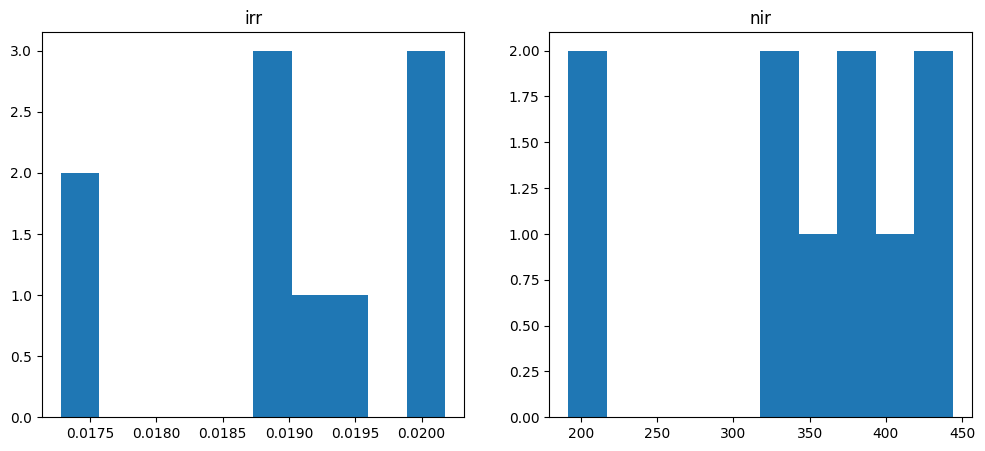

In [22]:
def test_results_distributions(promotion_strategy, numbers_run=10):
    print("Run the model for {} times".format(numbers_run))
    test_data = pd.read_csv('Test.csv')
    df = test_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
    irrs = []
    nirs = []
    for i in range(numbers_run):
        promos = promotion_strategy(df)
        score_df = test_data.iloc[np.where(promos == 'Yes')]    
        irr, nir = score(score_df)
        irrs.append(irr)
        nirs.append(nir)
    print("Distributions of irr and nir:")
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.hist(irrs)
    a1=plt.title('irr')
    plt.subplot(1, 2, 2)
    plt.hist(nirs)
    a1=plt.title('nir')

test_results_distributions(promotion_strategy)